In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.grid_search import GridSearchCV
from utils import *

In [2]:
train = pd.read_csv('train_dataset.csv')

In [3]:
train.head()

,id,location,fault_severity,event_type 1,event_type 10,event_type 11,event_type 12,event_type 13,event_type 14,event_type 15,...,feature 90 volume,feature 91 volume,feature 92 volume,feature 93 volume,feature 94 volume,feature 95 volume,feature 96 volume,feature 97 volume,feature 98 volume,feature 99 volume
0,14121,location 118,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9320,location 91,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,14394,location 152,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,8218,location 931,1,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,14804,location 120,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
test = pd.read_csv('test_dataset.csv')

In [5]:
train.shape

(7381, 843)

In [6]:
test.shape

(11171, 842)

In [7]:
sample = pd.read_csv('sample_submission.csv')

In [127]:
sample.head()

,id,predict_0,predict_1,predict_2
0,11066,0,1,0
1,18000,0,1,0
2,16964,0,1,0
3,4795,0,1,0
4,3392,0,1,0


In [118]:
train_event_start = 3
test_event_start = train_event_start - 1
train_feature_start = 56
train_event_end = train_feature_start
test_feature_start = train_feature_start - 1
test_event_end = test_feature_start
train_resource_start = 442
train_feature_end = train_resource_start
test_resource_start = train_resource_start - 1
test_feature_end = test_resource_start
train_severity_start = 452
train_resource_end = train_severity_start
test_severity_start = train_severity_start - 1
test_resource_end = test_severity_start
train_volume_start = 457
train_severity_end = train_volume_start
test_volume_start = train_volume_start - 1
test_severity_end = test_volume_start
train_end = 843
test_end = train_end - 1

In [53]:
ranges = [
    ('event', range(train_event_start, train_feature_start)),
    ('feature', range(train_feature_start, train_resource_start)), 
    ('resource', range(train_resource_start, train_severity_start)),
    ('severity', range(train_severity_start, train_volume_start)),
    ('volume', range(train_volume_start, train_end))]

In [50]:
def powerset(l):
    if not l: return [[]]
    return p(l[1:]) + [[l[0]] + x for x in p(l[1:])]

In [54]:
full_ranges = powerset(ranges)

In [72]:
def list_sum(args):
    res = []
    for arg in args:
        res += arg
    return res

In [80]:
def string_sum(args):
    res = ''
    for arg in args:
        res += arg + ' '
    return res

In [107]:
rfc = RandomForestClassifier()
insample_scores = []
outsample_scores = []
com_cats = []
for com_range in full_ranges[1:]:
    col_ids = list_sum(x[1] for x in com_range)
    com_cat = string_sum(x[0] for x in com_range)
    errors = get_score(
        train.iloc[:, col_ids].values,
        train.loc[:, 'fault_severity'].values,
        rfc)
    insample_scores.append(errors[0])
    outsample_scores.append(errors[1])
    com_cats.append(com_cat)
res = pd.DataFrame({'insample_scores': insample_scores, 'outsample_scores': outsample_scores}, index=com_cats)

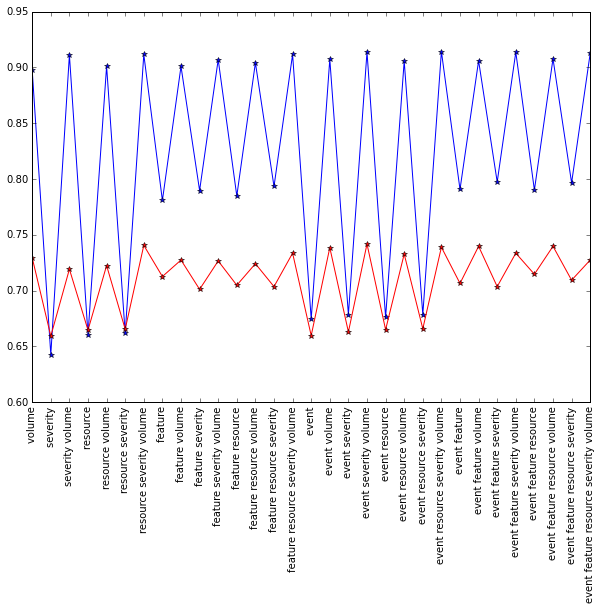

In [111]:
plt.figure(figsize=(10, 7))
ax = plt.subplot(111)
res.loc[:, 'insample_scores'].plot(kind='line', ax=ax, rot=90, marker='*')
res.loc[:, 'outsample_scores'].plot(kind='line', ax=ax, color='r', rot=90, marker='*')
plt.xticks(range(len(res.index)), res.index)
plt.show()

In [10]:
param = {'n_estimators': list(range(30, 80))}
rfc = RandomForestClassifier(n_jobs=-1)
gs = GridSearchCV(rfc, param)
gs.fit(train.loc[:, 'event_type 1':], train.loc[:, 'fault_severity'])

In [14]:
gs.best_params_

{'n_estimators': 46}

In [16]:
param = {'min_samples_split': list(range(2, 10))}
rfc = RandomForestClassifier(n_estimators=46, n_jobs=-1)
gs = GridSearchCV(rfc, param)
gs.fit(train.loc[:, 'event_type 1':], train.loc[:, 'fault_severity'])

In [20]:
gs.best_params_

{'min_samples_split': 8}

In [21]:
gs.best_score_

0.74827259178973038

In [112]:
rfc = RandomForestClassifier(n_estimators=46, min_samples_split=8)
insample_scores = []
outsample_scores = []
com_cats = []
for com_range in full_ranges[1:]:
    col_ids = list_sum(x[1] for x in com_range)
    com_cat = string_sum(x[0] for x in com_range)
    errors = get_score(
        train.iloc[:, col_ids].values,
        train.loc[:, 'fault_severity'].values,
        rfc)
    insample_scores.append(errors[0])
    outsample_scores.append(errors[1])
    com_cats.append(com_cat)
res = pd.DataFrame({'insample_scores': insample_scores, 'outsample_scores': outsample_scores}, index=com_cats)

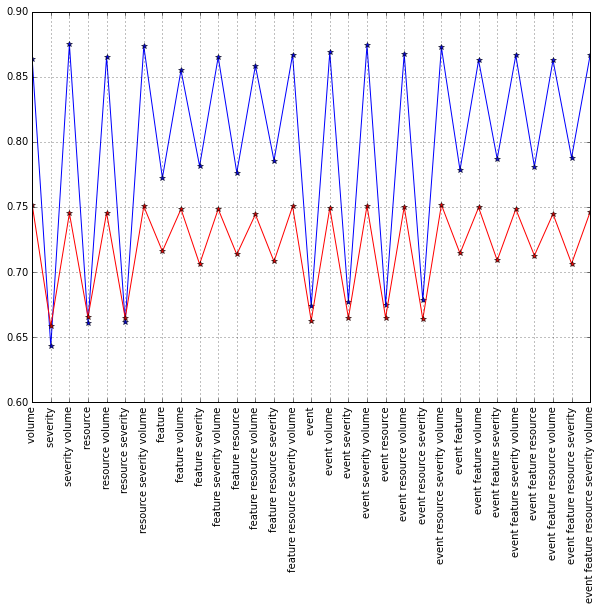

In [114]:
plt.figure(figsize=(10, 7))
ax = plt.subplot(111)
res.loc[:, 'insample_scores'].plot(kind='line', ax=ax, rot=90, marker='*')
res.loc[:, 'outsample_scores'].plot(kind='line', ax=ax, color='r', rot=90, marker='*')
plt.xticks(range(len(res.index)), res.index)
plt.grid()
plt.show()

In [137]:
rfc = RandomForestClassifier(n_estimators=46, min_samples_split=8)
insample_scores = []
outsample_scores = []
com_cats = []
for com_range in full_ranges[1:]:
    col_ids = list_sum(x[1] for x in com_range)
    com_cat = string_sum(x[0] for x in com_range)
    errors = get_evaluate(
        train.iloc[:, col_ids].values,
        train.loc[:, 'fault_severity'].values,
        rfc,
        random_state=487)
    insample_scores.append(errors[0])
    outsample_scores.append(errors[1])
    com_cats.append(com_cat)
res = pd.DataFrame({'insample_evaluates': insample_scores, 'outsample_evaluates': outsample_scores}, index=com_cats)

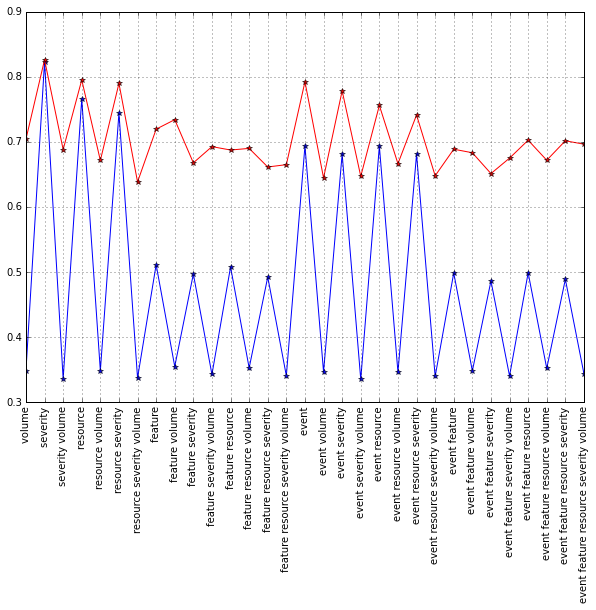

In [138]:
plt.figure(figsize=(10, 7))
ax = plt.subplot(111)
res.loc[:, 'insample_evaluates'].plot(kind='line', ax=ax, rot=90, marker='*')
res.loc[:, 'outsample_evaluates'].plot(kind='line', ax=ax, color='r', rot=90, marker='*')
plt.xticks(range(len(res.index)), res.index)
plt.grid()
plt.show()

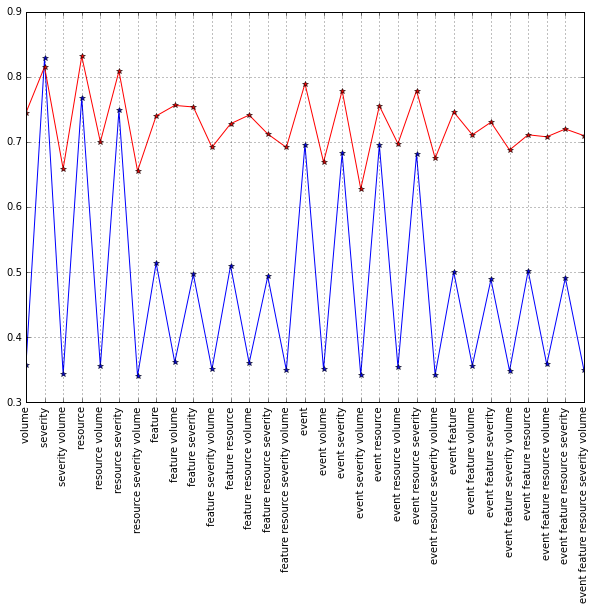

In [116]:
plt.figure(figsize=(10, 7))
ax = plt.subplot(111)
res.loc[:, 'insample_evaluates'].plot(kind='line', ax=ax, rot=90, marker='*')
res.loc[:, 'outsample_evaluates'].plot(kind='line', ax=ax, color='r', rot=90, marker='*')
plt.xticks(range(len(res.index)), res.index)
plt.grid()
plt.show()

In [139]:
param = {'n_estimators': list(range(30, 80))}
rfc = RandomForestClassifier(n_jobs=-1)
gs = GridSearchCV(rfc, param)
gs.fit(
    train
    .iloc[
        :, 
        list(range(train_event_start, train_event_end)) +
        list(range(train_severity_start, train_severity_end)) +
        list(range(train_volume_start, train_end))], 
    train.loc[:, 'fault_severity'])

GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params={}, iid=True, loss_func=None, n_jobs=1,
       param_grid={'n_estimators': [30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79]},
       pre_dispatch='2*n_jobs', refit=True, score_func=None, scoring=None,
       verbose=0)

In [140]:
gs.best_params_

{'n_estimators': 72}

In [143]:
param = {'min_samples_split': list(range(2, 10))}
rfc = RandomForestClassifier(n_estimators=46, n_jobs=-1)
gs = GridSearchCV(rfc, param)
gs.fit(
    train
    .iloc[
        :, 
        list(range(train_event_start, train_event_end)) +
        list(range(train_severity_start, train_severity_end)) +
        list(range(train_volume_start, train_end))], 
    train.loc[:, 'fault_severity'])

GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=46, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params={}, iid=True, loss_func=None, n_jobs=1,
       param_grid={'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9]},
       pre_dispatch='2*n_jobs', refit=True, score_func=None, scoring=None,
       verbose=0)

In [144]:
gs.best_params_

{'min_samples_split': 9}

In [8]:
rfc = RandomForestClassifier(n_estimators=72, min_samples_split=9)

In [9]:
rfc.fit(
    train
    .iloc[
        :, 
        list(range(train_event_start, train_event_end)) +
        list(range(train_severity_start, train_severity_end)) +
        list(range(train_volume_start, train_end))], 
    train.loc[:, 'fault_severity'])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=9,
            min_weight_fraction_leaf=0.0, n_estimators=72, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [10]:
prob = rfc.predict_proba(
    test
    .iloc[
        :, 
        list(range(test_event_start, test_event_end)) +
        list(range(test_severity_start, test_severity_end)) +
        list(range(test_volume_start, test_end))])

In [11]:
prob.shape

(11171, 3)

In [12]:
rfc_res = pd.DataFrame({
    'id': sample.loc[:, 'id'].values, 
    'predict_0': prob[:, 0],
    'predict_1': prob[:, 1],
    'predict_2': prob[:, 2]})

In [13]:
rfc_res.head()

,id,predict_0,predict_1,predict_2
0,11066,0.994985,0.005015,0.000000
1,18000,0.164473,0.014669,0.820859
2,16964,0.998843,0.001157,0.000000
3,4795,0.597506,0.378960,0.023534
4,3392,0.204114,0.795886,0.000000


In [14]:
rfc_res.to_csv('randomforest.csv', index=False)